In [2]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Load terrain data (Assume it's a heightmap stored in a 2D NumPy array)
terrain_data = np.genfromtxt("terrain.csv", delimiter=",")

# Define grid points (Assuming equal spacing)
x = np.linspace(0, 1, terrain_data.shape[0])  # Normalized x-coordinates
y = np.linspace(0, 1, terrain_data.shape[1])  # Normalized y-coordinates

# Create an interpolation function
terrain_function = RegularGridInterpolator((x, y), terrain_data, method="cubic")

# Example: Get height at (0.3, 0.7)
height = terrain_function([0.3, 0.7])
print("Height at (0.3, 0.7):", height)


Height at (0.3, 0.7): [27.80373419]


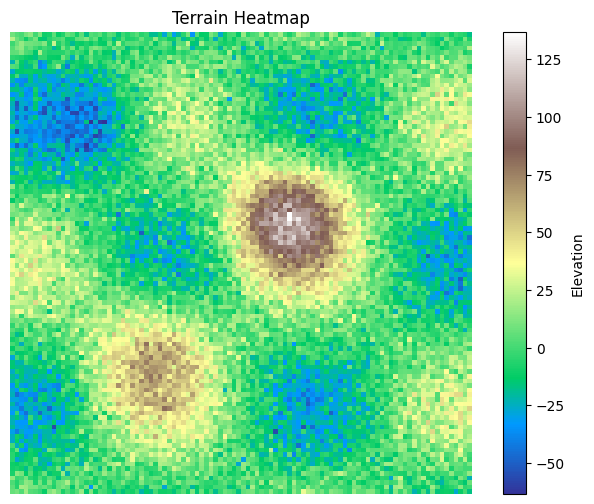

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the terrain data
terrain_data = np.genfromtxt("terrain.csv", delimiter=",")

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.axis('off')
plt.imshow(terrain_data, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation")
plt.title("Terrain Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [13]:
%matplotlib tk

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

C:\Users\harsh\AppData\Local\Temp\ipykernel_34380\2293884654.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()  # open the plot in a new window


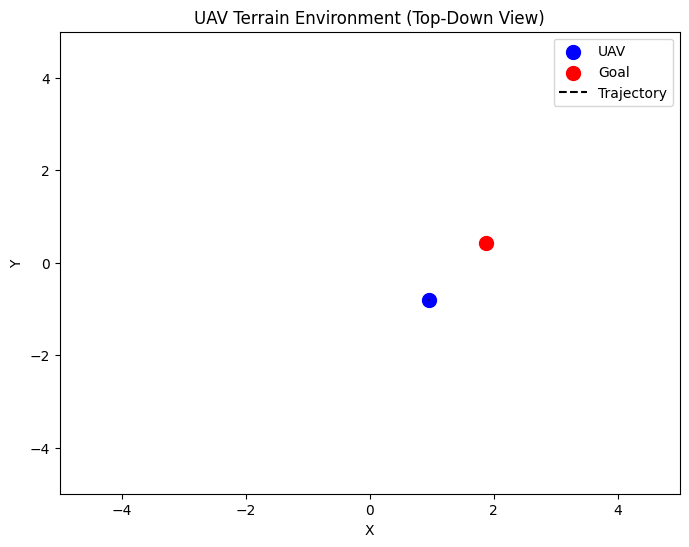

Episode finished!


In [15]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

class UAVTerrainEnv(gym.Env):
    def __init__(self):
        super(UAVTerrainEnv, self).__init__()
        
        # Load terrain data from CSV (assumes shape 100x100)
        self.terrain_data = np.genfromtxt("terrain.csv", delimiter=",")
        self.grid_size = self.terrain_data.shape[0]
        
        # Define the x-y bounds of the terrain
        self.x_bounds = (-5, 5)
        self.y_bounds = (-5, 5)
        
        # Create grid points for interpolation
        self.x_range = np.linspace(self.x_bounds[0], self.x_bounds[1], self.grid_size)
        self.y_range = np.linspace(self.y_bounds[0], self.y_bounds[1], self.grid_size)
        
        # Create an interpolator for continuous terrain elevation lookup
        self.terrain_function = RegularGridInterpolator(
            (self.x_range, self.y_range), self.terrain_data, method="cubic"
        )
        
        self.terrain_min = float(np.min(self.terrain_data))
        self.terrain_max = float(np.max(self.terrain_data))
        
        # Define UAV altitude limits: UAV must be above terrain and below a max altitude
        self.z_bounds = (self.terrain_min, 20)
        
        # Observation space: position (x,y,z), velocity (vx, vy, vz), and goal position (x,y,z)
        obs_low = np.array([
            self.x_bounds[0], self.y_bounds[0], self.z_bounds[0],
            -5, -5, -5,
            self.x_bounds[0], self.y_bounds[0], self.z_bounds[0]
        ], dtype=np.float32)
        obs_high = np.array([
            self.x_bounds[1], self.y_bounds[1], self.z_bounds[1],
            5, 5, 5,
            self.x_bounds[1], self.y_bounds[1], self.z_bounds[1]
        ], dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)
        
        # Action space: accelerations in x, y, and z directions
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)
        
        # Dynamics parameter: time step
        self.dt = 0.1
        
        # Collision margin: UAV must remain at least this far above the terrain
        self.collision_margin = 0.5
        
        # Generate a valid goal position within limits
        self.goal = self._generate_goal_position()
        
        # For trajectory tracking (for visualization)
        self.trajectory = []
        
        # Setup a new window for visualization (make sure to run with an interactive backend)
        plt.ion()  # enable interactive mode
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.fig.show()  # open the plot in a new window
        
        self.reset()

    def _generate_goal_position(self):
        # Generate a random goal position within x-y bounds and above the terrain.
        x_goal = np.random.uniform(*self.x_bounds)
        y_goal = np.random.uniform(*self.y_bounds)
        ground_elev = self.get_terrain_elevation(x_goal, y_goal)
        # Ensure goal altitude is at least 1 unit above the ground and within z_bounds.
        z_goal = np.random.uniform(ground_elev + 1.0, self.z_bounds[1])
        return np.array([x_goal, y_goal, z_goal], dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Randomly initialize the UAV's start position within x-y bounds.
        x_init = np.random.uniform(*self.x_bounds)
        y_init = np.random.uniform(*self.y_bounds)
        ground_elev = self.get_terrain_elevation(x_init, y_init)
        # Start at least 1 unit above the ground.
        z_init = np.random.uniform(ground_elev + 1.0, self.z_bounds[1])
        self.position = np.array([x_init, y_init, z_init], dtype=np.float32)
        
        # Initialize velocity to zero.
        self.velocity = np.zeros(3, dtype=np.float32)
        
        # Optionally, reset the goal position (if you want a new goal each episode)
        self.goal = self._generate_goal_position()
        
        # Build the state: position, velocity, and goal position
        self.state = np.concatenate([self.position, self.velocity, self.goal])
        
        # Reset the trajectory history.
        self.trajectory = [self.position.copy()]
        return self.state, {}

    def step(self, action):
        # Clip the action to ensure it stays within the defined limits.
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update velocity and position based on the action and dynamics.
        self.velocity += action * self.dt
        self.position += self.velocity * self.dt
        
        # Clip x and y positions within the bounds.
        self.position[0] = np.clip(self.position[0], *self.x_bounds)
        self.position[1] = np.clip(self.position[1], *self.y_bounds)
        # Clip z position within the altitude limits.
        self.position[2] = np.clip(self.position[2], self.z_bounds[0], self.z_bounds[1])
        
        # Check for collision: UAV must be above the terrain + collision_margin.
        ground_elev = self.get_terrain_elevation(self.position[0], self.position[1])
        collision = self.position[2] < ground_elev + self.collision_margin
        
        # Update state and trajectory.
        self.state = np.concatenate([self.position, self.velocity, self.goal])
        self.trajectory.append(self.position.copy())
        
        # Compute reward based on the distance to the goal; heavy penalty on collision.
        distance = np.linalg.norm(self.position - self.goal)
        reward = -distance
        if collision:
            reward -= 100  # collision penalty
        
        # Episode termination if the UAV reaches near the goal or collides.
        done = (distance < 0.5) or collision
        return self.state, reward, done, False, {}

    def get_terrain_elevation(self, x, y):
        # Returns the interpolated elevation at (x, y)
        return self.terrain_function([[x, y]])[0]
    
    def render(self, mode='human'):
        # Clear the current axis.
        self.ax.clear()
        self.ax.set_xlim(self.x_bounds)
        self.ax.set_ylim(self.y_bounds)
        self.ax.set_title("UAV Terrain Environment (Top-Down View)")
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        
        # Plot the UAV's current position as a blue dot.
        self.ax.scatter(self.position[0], self.position[1], color='blue', s=100, label='UAV')
        # Plot the goal position as a red dot.
        self.ax.scatter(self.goal[0], self.goal[1], color='red', s=100, label='Goal')
        # Plot the trajectory as a dashed line.
        traj = np.array(self.trajectory)
        self.ax.plot(traj[:, 0], traj[:, 1], linestyle='--', color='black', label='Trajectory')
        
        self.ax.legend()
        # Update the figure in the new window.
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

# Testing the environment with visualization in a new window.
if __name__ == "__main__":
    env = UAVTerrainEnv()
    state, _ = env.reset()
    
    for _ in range(100):
        action = env.action_space.sample()  # Replace with your control logic or RL agent.
        state, reward, done, _, _ = env.step(action)
        env.render()
        plt.pause(0.05)  # Pause to update the plot.
        if done:
            print("Episode finished!")
            break
    plt.ioff()
    plt.show()
